# EDA of Carbon Intensity (July 2018 - Dec 2020)

# Imports

In [104]:
%%time
!pip install darts --quiet

CPU times: user 92.2 ms, sys: 84.3 ms, total: 177 ms
Wall time: 6.19 s


In [105]:
import os
import boto3

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sagemaker import get_execution_role

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.utils.missing_values import extract_subseries, fill_missing_values, missing_values_ratio
from darts.utils.statistics import plot_hist, plot_acf, plot_pacf, check_seasonality, plot_residuals_analysis, stationarity_test_kpss, extract_trend_and_seasonality

# Global variables

In [106]:
CO2_INTENSITY_START_TIMESTAMP = pd.Timestamp('2018-07-01 08:00:00')
SPLIT_TIMESTAMP = pd.Timestamp('2021-01-01 00:00:00')

sns.set_theme(rc={
    "figure.figsize":(16, 9),
    "axes.titlesize": 30
    })
sns.set_style('whitegrid')

# S3 connection and load dataframe

In [107]:
# S3 connection
role = get_execution_role()
BUCKET='ucb-mids-capstone'

# Load dataframe
data_key = 'Data/Aggregated_Data/train_caiso_eia_and_radiation.csv'
data_location = f's3://{BUCKET}/{data_key}'
df = pd.read_csv(data_location)
df['utc_time'] = df['utc_time'].str.slice(stop=-6) # Drop +00:00 to play nice with Darts
df['utc_time'] = pd.to_datetime(df['utc_time']) # Convert to datetime
df.set_index('utc_time', inplace=True) # Note DatetimeIndex rather than RangeIndex

# Only look at a data prior to validation set for which CO2 intensity exists
df = df[(df.index >= CO2_INTENSITY_START_TIMESTAMP) & (df.index < SPLIT_TIMESTAMP)].copy()

print("Shape is: {}".format(df.shape))

# Make TimeSeries objects for CO2 intensity and curtailment
co2_series = TimeSeries.from_series(df['co2_emissions_intensity_for_consumed_electricity_eia'])

Shape is: (21952, 69)


In [108]:
df['week_of_year'] = df.index.isocalendar().week

# Time series plots

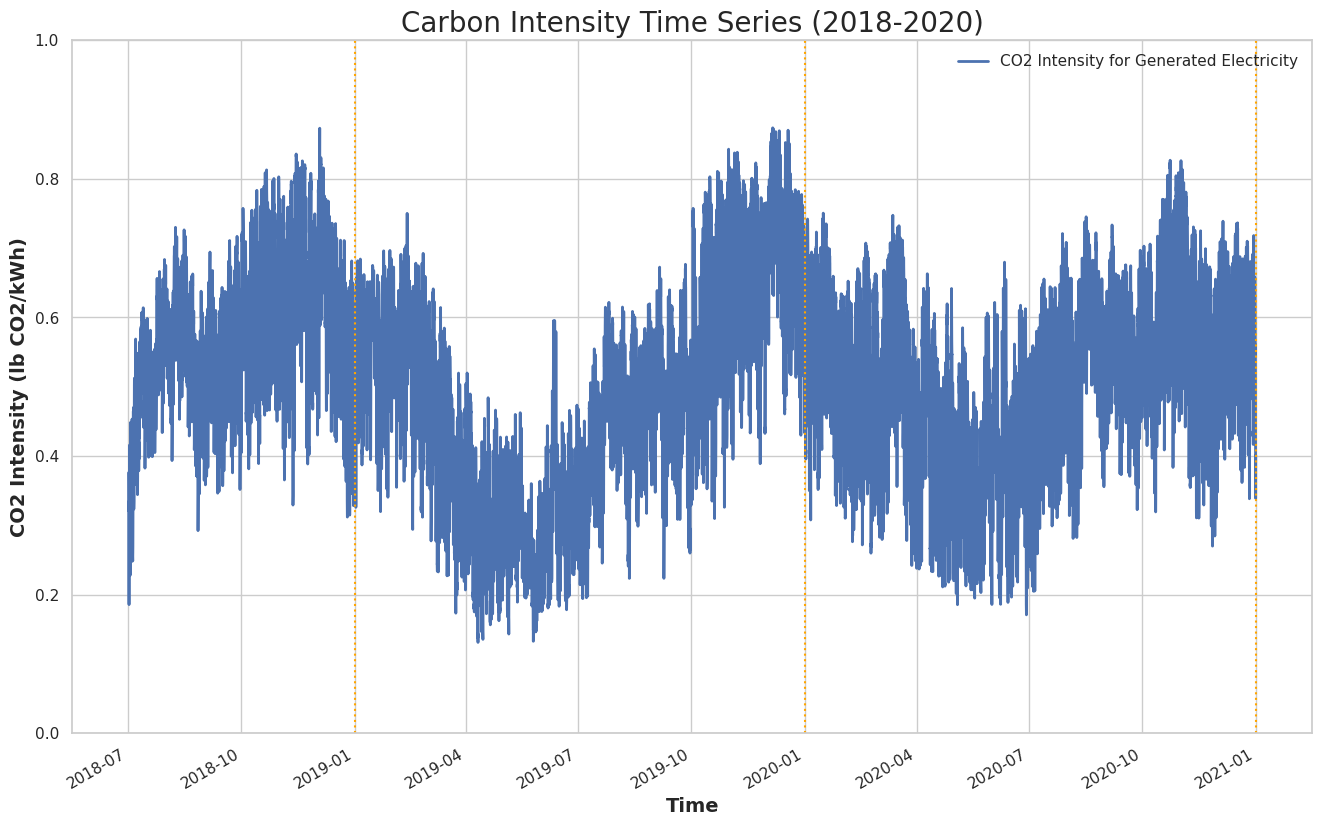

In [109]:
plt.figure(figsize=(16, 9))
co2_series.plot()
plt.title('Carbon Intensity Time Series (2018-2020)', fontsize=20)
plt.xlabel('Time', fontsize=14)
plt.ylabel('CO2 Intensity (lb CO2/kWh)', fontsize=14)
plt.ylim((0, 1))

plt.axvline(x=pd.Timestamp('2018-12-31 23:00:00'), color='orange', linestyle='dotted')
plt.axvline(x=pd.Timestamp('2019-12-31 23:00:00'), color='orange', linestyle='dotted')
plt.axvline(x=pd.Timestamp('2020-12-31 23:00:00'), color='orange', linestyle='dotted')

leg=plt.legend()
leg.get_texts()[0].set_text('CO2 Intensity for Generated Electricity')
plt.show()

# Distribution of target variable

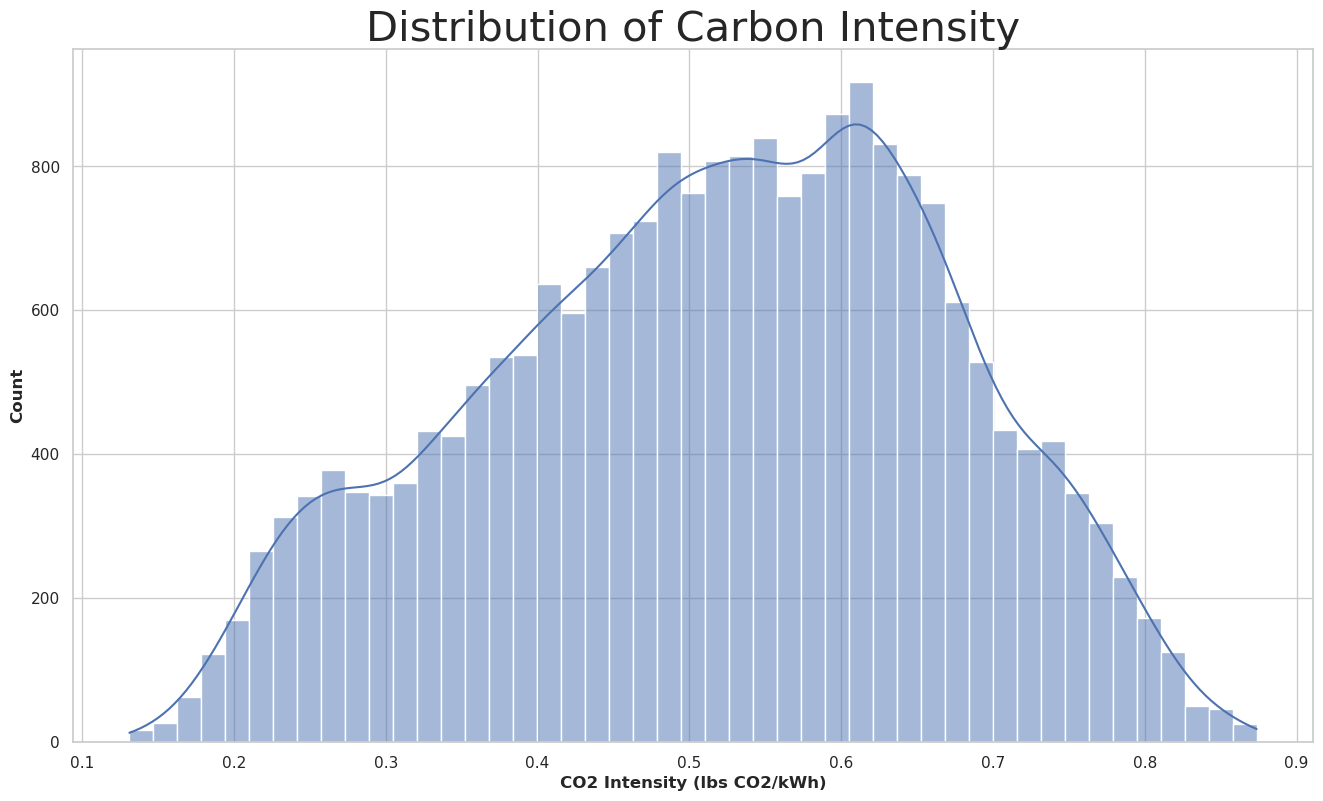

In [110]:
sns.histplot(data=df,
             x='co2_emissions_intensity_for_consumed_electricity_eia',
             kde=True)
plt.xlabel('CO2 Intensity (lbs CO2/kWh)')
plt.title('Distribution of Carbon Intensity')
plt.show()

In [111]:
# Distribution of CO2 intensity across training period
df['co2_emissions_intensity_for_consumed_electricity_eia'].describe()

count    21952.000000
mean         0.517171
std          0.152763
min          0.131115
25%          0.407506
50%          0.527530
75%          0.631488
max          0.873635
Name: co2_emissions_intensity_for_consumed_electricity_eia, dtype: float64

# Target variable grouped by time

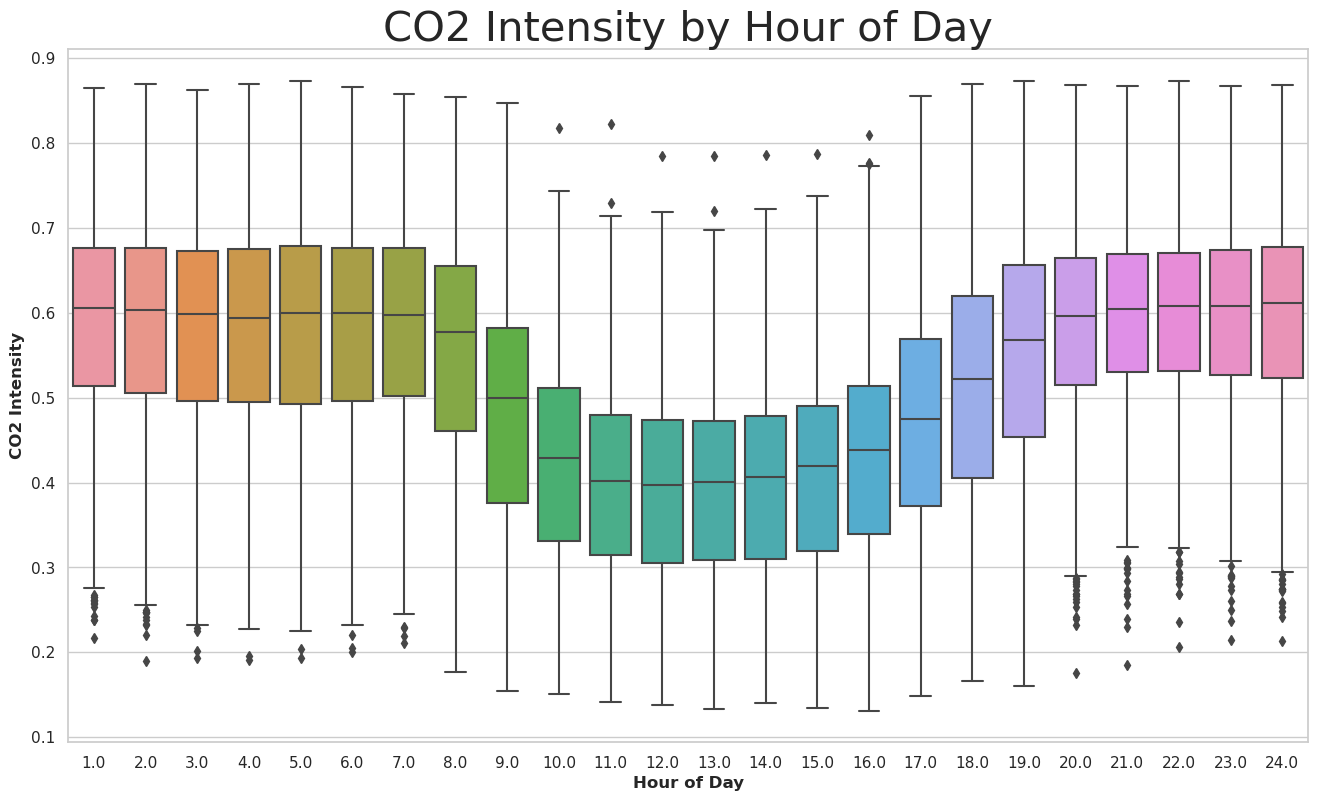

In [112]:
sns.boxplot(x='hour',
            y='co2_emissions_intensity_for_consumed_electricity_eia',
            data=df)
plt.title('CO2 Intensity by Hour of Day')
plt.ylabel('CO2 Intensity')
plt.xlabel('Hour of Day')
plt.show()

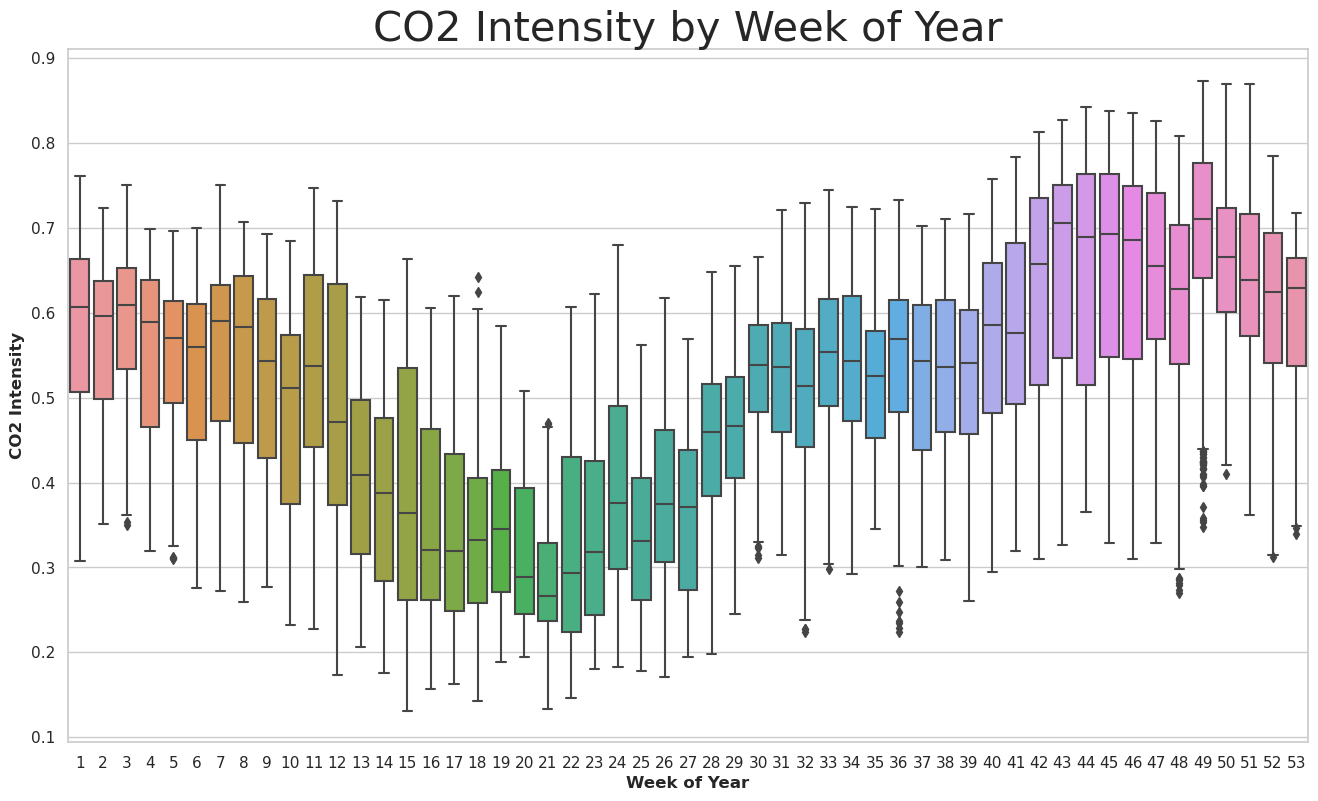

In [114]:
sns.boxplot(x='week_of_year',
            y='co2_emissions_intensity_for_consumed_electricity_eia',
            data=df)
plt.title('CO2 Intensity by Week of Year')
plt.ylabel('CO2 Intensity')
plt.xlabel('Week of Year')
plt.show()

In [115]:
# df.groupby(df['week_of_year'])['co2_emissions_intensity_for_consumed_electricity_eia'].median()

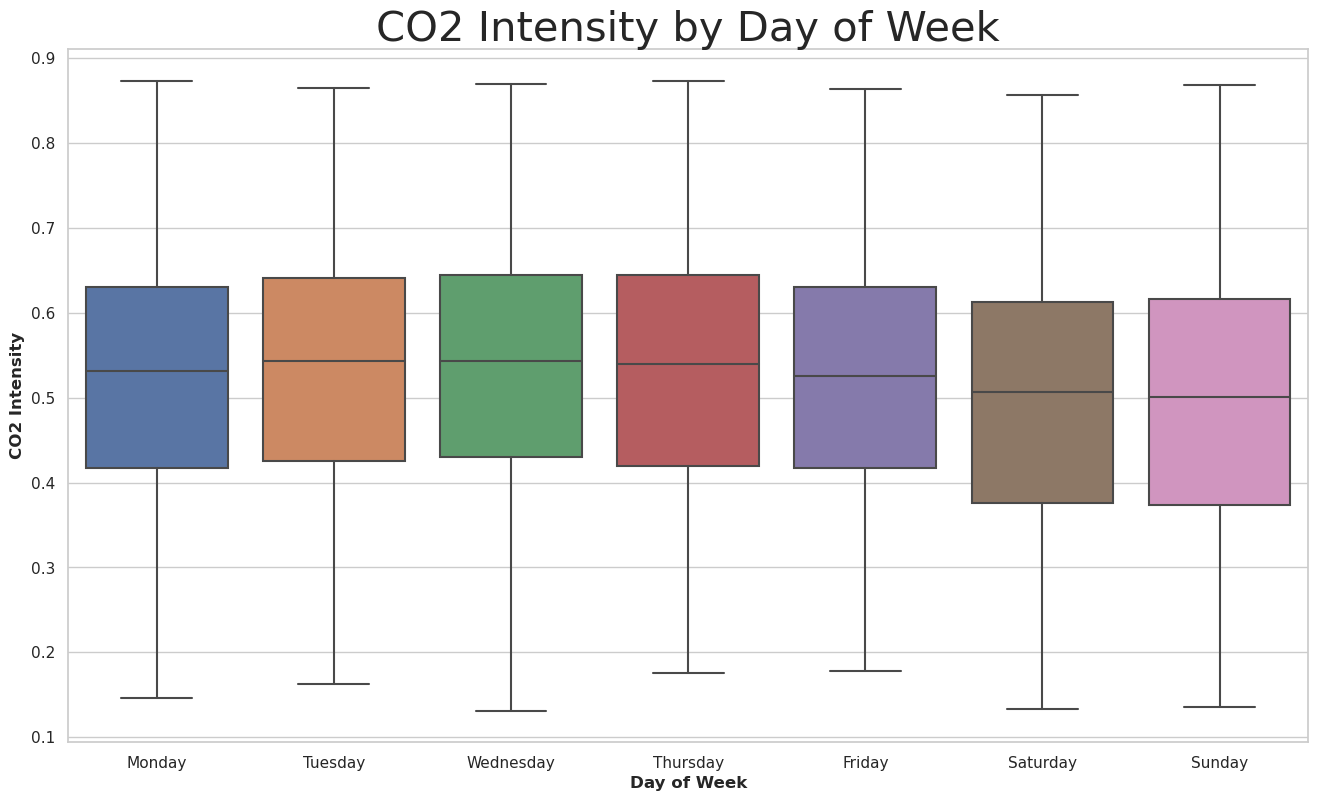

In [117]:
sns.boxplot(x='day_of_week',
            y='co2_emissions_intensity_for_consumed_electricity_eia',
            data=df)
plt.xticks([0, 1, 2, 3, 4, 5, 6],
           ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('CO2 Intensity by Day of Week')
plt.ylabel('CO2 Intensity')
plt.xlabel('Day of Week')
plt.show()

In [118]:
df.groupby(df['day_of_week'])['co2_emissions_intensity_for_consumed_electricity_eia'].median()

day_of_week
0.0    0.531067
1.0    0.542979
2.0    0.543829
3.0    0.539566
4.0    0.525362
5.0    0.506890
6.0    0.500951
Name: co2_emissions_intensity_for_consumed_electricity_eia, dtype: float64

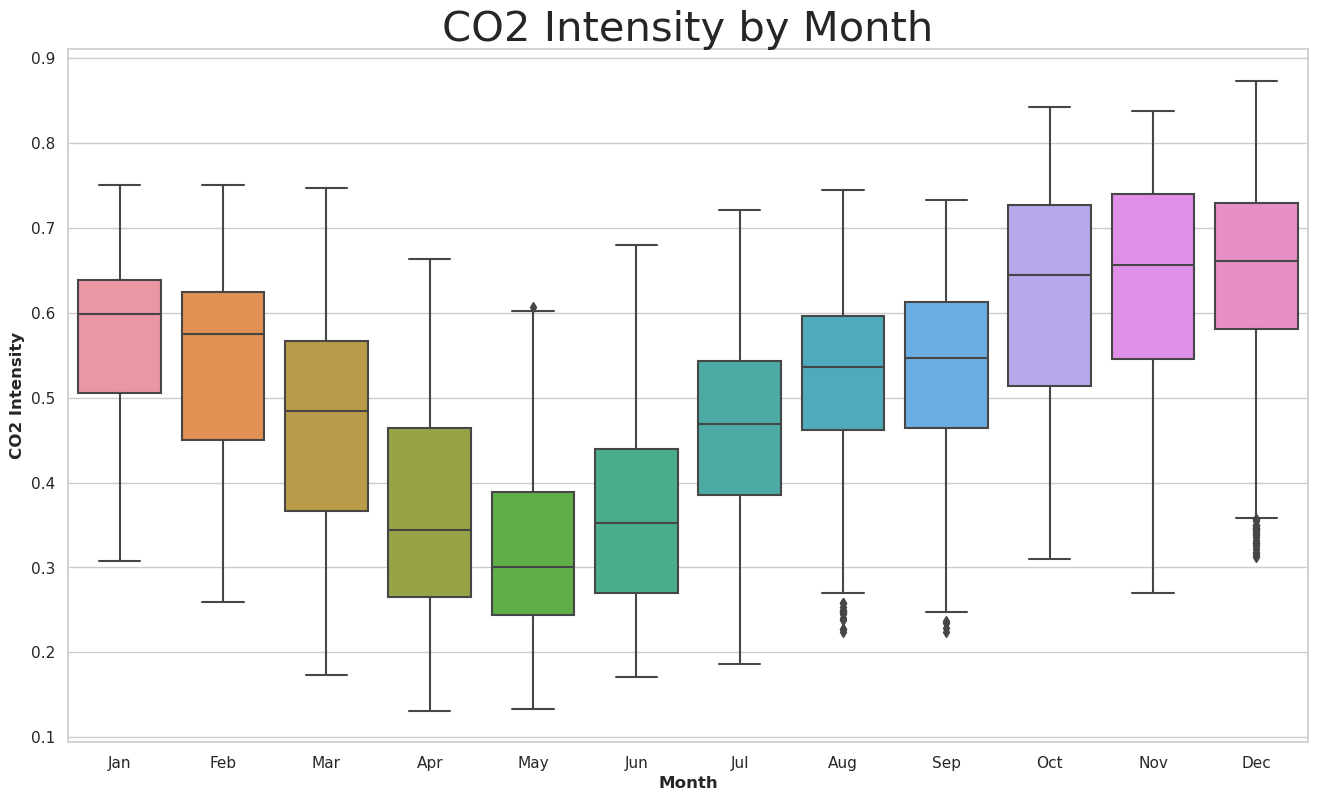

In [119]:
sns.boxplot(x='month',
            y='co2_emissions_intensity_for_consumed_electricity_eia',
            data=df)
plt.xticks(list(range(12)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('CO2 Intensity by Month')
plt.ylabel('CO2 Intensity')
plt.xlabel('Month')
plt.show()

In [120]:
df.groupby(df['month'])['co2_emissions_intensity_for_consumed_electricity_eia'].median()

month
1.0     0.598291
2.0     0.575619
3.0     0.484681
4.0     0.344500
5.0     0.300934
6.0     0.352150
7.0     0.469046
8.0     0.535987
9.0     0.547408
10.0    0.644462
11.0    0.656020
12.0    0.660654
Name: co2_emissions_intensity_for_consumed_electricity_eia, dtype: float64

# Time series analysis plots

## Differencing

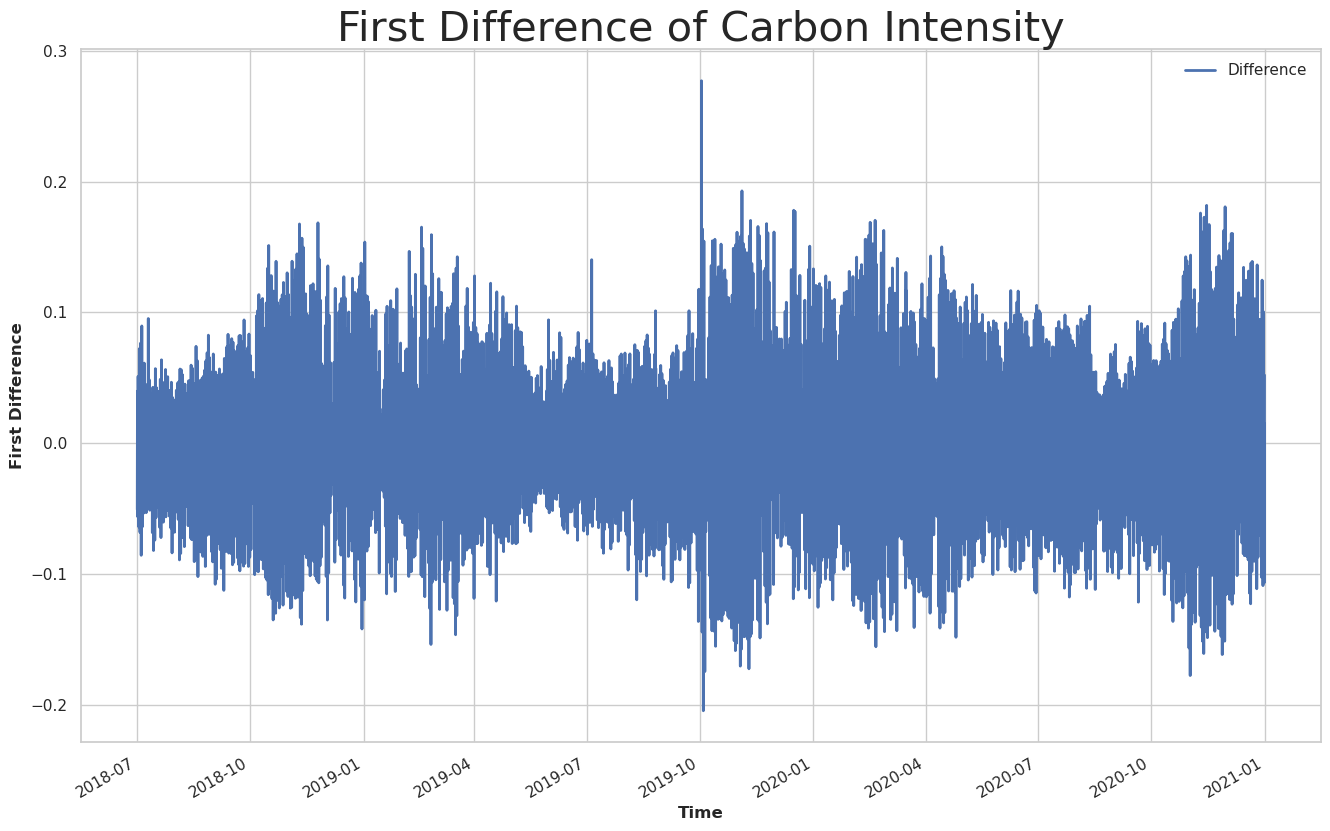

In [121]:
plt.figure(figsize=(16, 9))
co2_series.diff().plot(label='Difference')
plt.title('First Difference of Carbon Intensity')
plt.xlabel('Time')
plt.ylabel('First Difference')
plt.show()

Note variance in magnitude in first order differences, some cycles where one hour's carbon insensity is very close to the previous hour's.

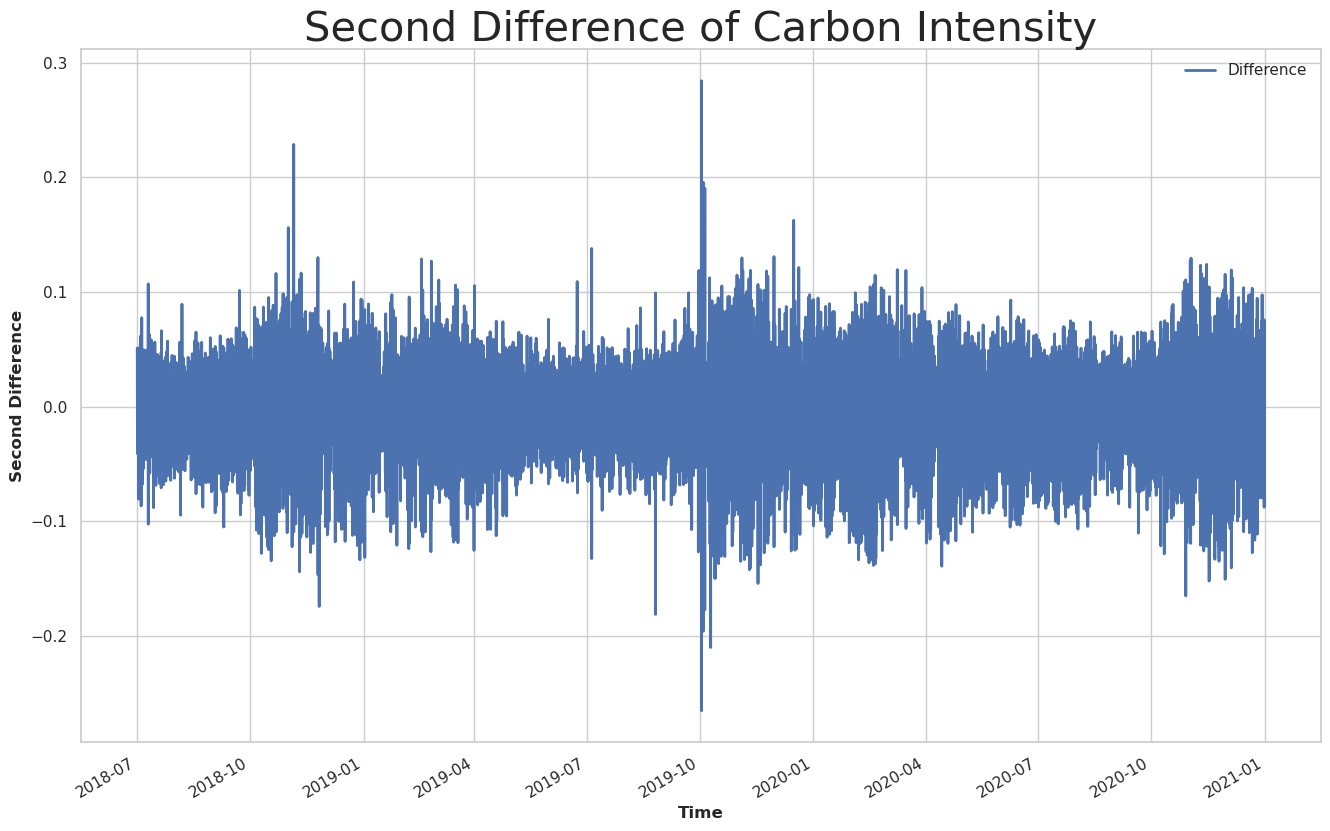

In [122]:
plt.figure(figsize=(16, 9))
co2_series.diff().diff().plot(label='Difference')
plt.title('Second Difference of Carbon Intensity')
plt.xlabel('Time')
plt.ylabel('Second Difference')
plt.show()

Not too much of an impact made by second differencing, may or may not be needed.

## Seasonality

In [123]:
# Check for seasonality on entire time series
no_seasonality = True

for m in range(2, 25):
    is_seasonal, period = check_seasonality(co2_series, m=m, alpha=0.05)
    if is_seasonal:
        no_seasonality = False
        print("There is seasonality of order {}.".format(period))
if no_seasonality:
    print("There is no seasonality detected.")

There is no seasonality detected.


In [124]:
# Check for seasonality only from start of 2019 to end of 2021
no_seasonality = True

start_ts = pd.Timestamp('2019-01-01 00:00:00')
end_ts = pd.Timestamp('2021-12-31 23:00:00')

for m in range(2, 25):
    is_seasonal, period = check_seasonality(co2_series.slice(start_ts=start_ts, end_ts=end_ts), m=m, alpha=0.05)
    if is_seasonal:
        no_seasonality = False
        print("There is seasonality of order {}.".format(period))
if no_seasonality:
    print("There is no seasonality detected.")

There is no seasonality detected.


## ACF & PACF

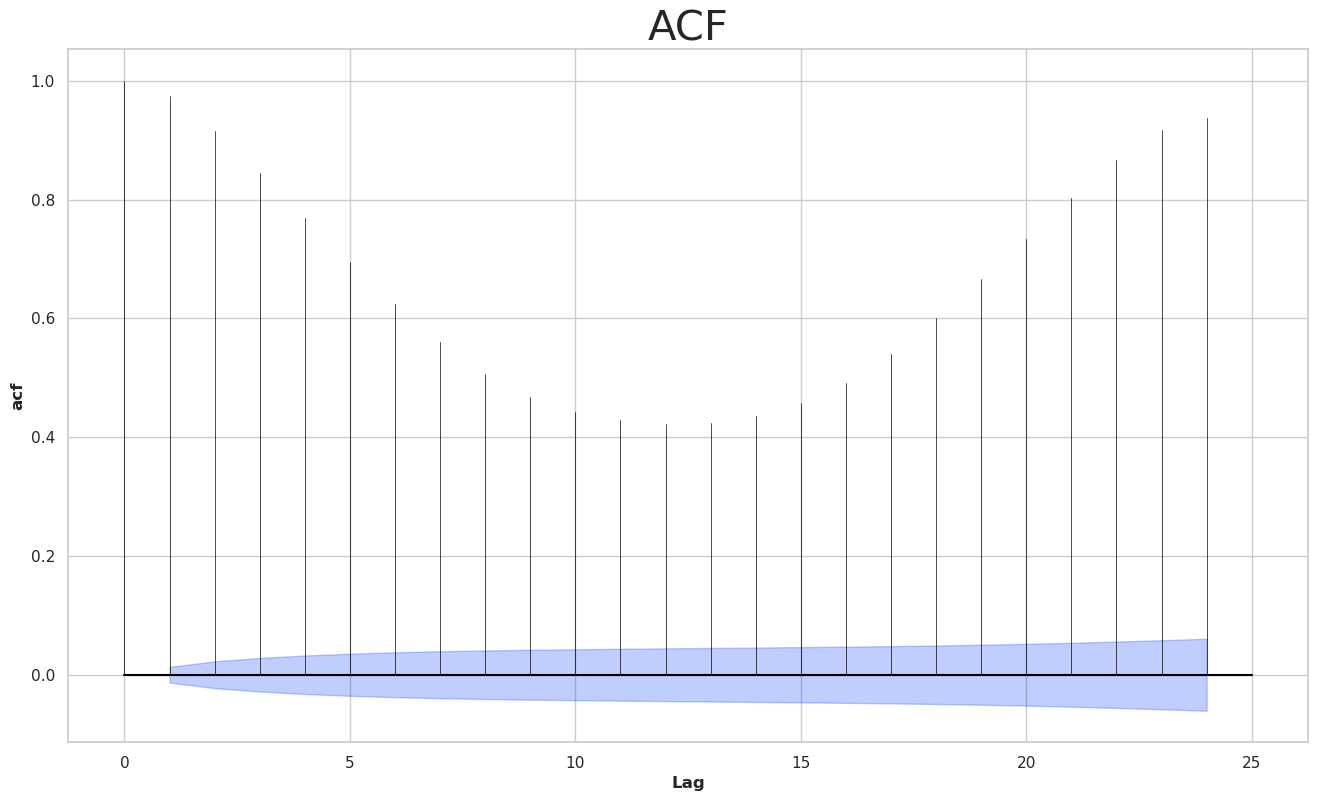

In [125]:
plot_acf(co2_series, alpha=0.05, fig_size=(16, 9))
plt.title('ACF')
plt.xlabel('Lag')
plt.ylabel('acf')
plt.show()

Seasonal effect shown in ACF via "valley" pattern. Carbon intensity 12 hours from previous value least autocorrelated. In contrast, carbon intensity at lags like 1 or 24 hours are highly autocorrelated. Suggestive of autoregressive (AR) process.

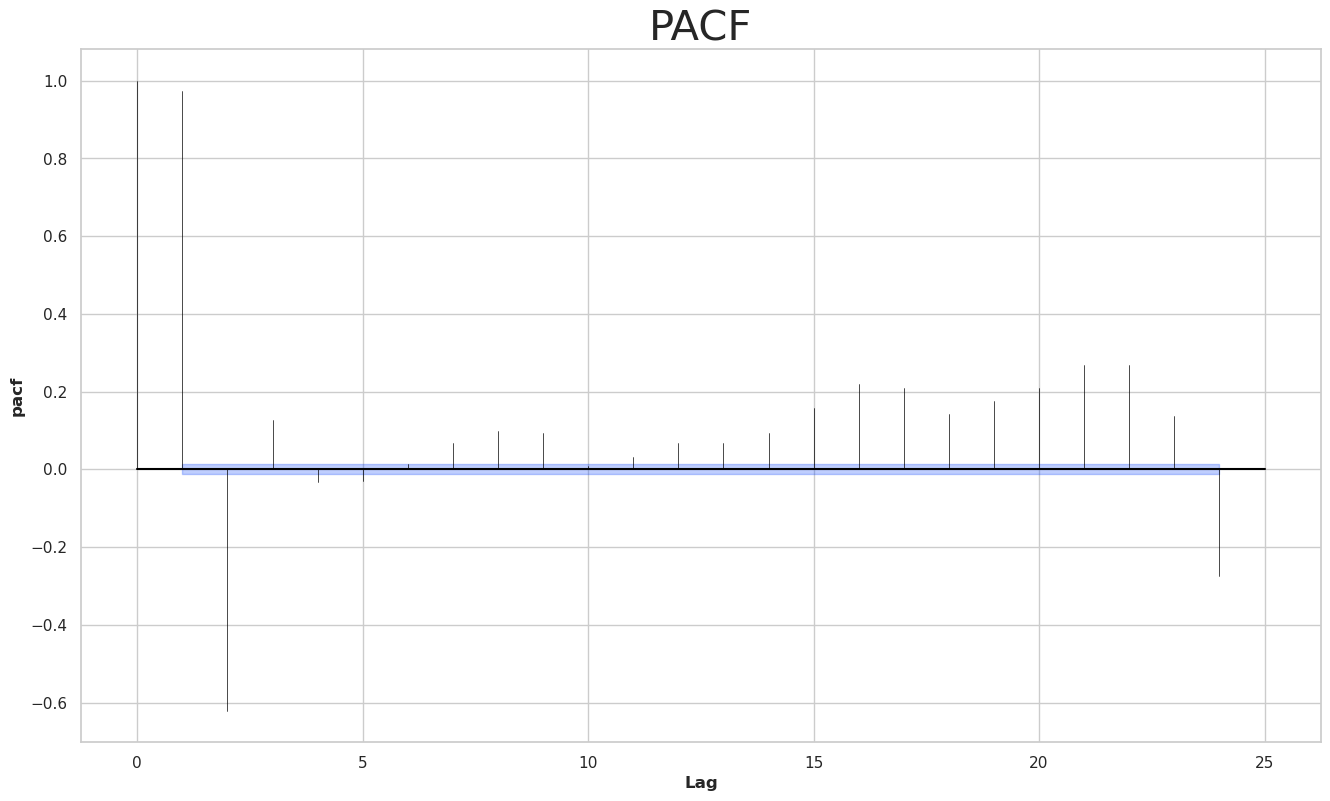

In [126]:
plot_pacf(co2_series, alpha=0.05, fig_size=(16, 9))
plt.title('PACF')
plt.xlabel('Lag')
plt.ylabel('pacf')
plt.show()

# CO2 emissions generated vs consumed

In [127]:
df['sum_of_emissions'] = df['co2_emissions_col_eia'] + df['co2_emissions_ng_eia'] + df['co2_emissions_oil_eia'] + df['co2_emissions_other_eia']
num_cross_validation_fail = df[df['sum_of_emissions'] != df['co2_emissions_consumed_eia']].shape[0]
print(f'There are {num_cross_validation_fail} rows where co2_emissions_consumed is not exactly the same as the sum of emissions from all sources.')

There are 21952 rows where co2_emissions_consumed is not exactly the same as the sum of emissions from all sources.


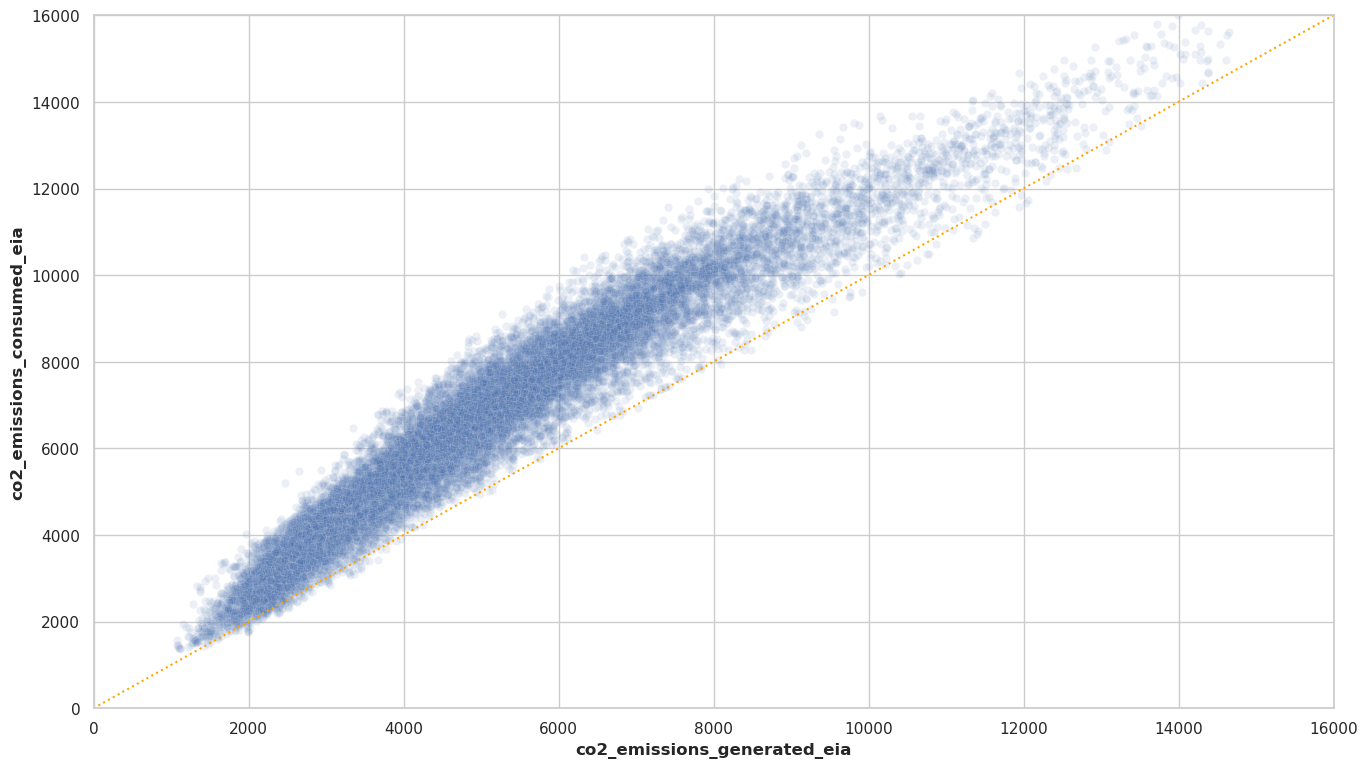

In [128]:
sns.scatterplot(x='co2_emissions_generated_eia',
                y='co2_emissions_consumed_eia',
                data=df,
               alpha=0.1)
plt.axline(xy1=(0,0), slope=1, color='orange', linestyle='dotted')
plt.xlim(0, 16000)
plt.ylim(0, 16000)
plt.show()

# Generation by source

In [129]:
# Dataframe of generation by source in MWh
df_gen = df[['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
             'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']]
df_gen

,ng_col_eia,ng_ng_eia,ng_nuc_eia,ng_oil_eia,ng_wat_eia,ng_sun_eia,ng_wnd_eia,ng_oth_eia
utc_time,,,,,,,,
2018-07-01 08:00:00,7.0,7675.0,2267.0,87.0,2560.0,0.0,3958.0,506.0
2018-07-01 09:00:00,9.0,5879.0,2261.0,87.0,2584.0,0.0,4087.0,540.0
2018-07-01 10:00:00,6.0,5635.0,2258.0,87.0,2506.0,0.0,3710.0,515.0
2018-07-01 11:00:00,8.0,5405.0,2257.0,87.0,2446.0,0.0,3630.0,566.0
2018-07-01 12:00:00,8.0,5592.0,2260.0,87.0,2609.0,0.0,3156.0,569.0
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,566.0,6342.0,1145.0,89.0,831.0,7851.0,2940.0,779.0
2020-12-31 20:00:00,401.0,6407.0,1145.0,89.0,865.0,8090.0,2536.0,776.0
2020-12-31 21:00:00,273.0,6597.0,1143.0,89.0,886.0,7861.0,3108.0,739.0


## Daily

In [130]:
# Groupby date to get daily average generation by source

# Group the original dataframe by date
df_daily_gen_by_source = df_gen.groupby(df.index.date).mean()

# Reset the index to turn the date into a column
df_daily_gen_by_source = df_daily_gen_by_source.reset_index()
df_daily_gen_by_source.rename(columns={'index':'date'}, inplace=True)

In [131]:
df_daily_gen_by_source

,date,ng_col_eia,ng_ng_eia,ng_nuc_eia,ng_oil_eia,ng_wat_eia,ng_sun_eia,ng_wnd_eia,ng_oth_eia
0,2018-07-01,8.062500,5627.812500,2260.437500,87.000000,2218.312500,5573.625000,2125.062500,525.187500
1,2018-07-02,8.500000,7680.625000,2262.125000,86.458333,3059.125000,4471.625000,3007.541667,529.291667
2,2018-07-03,10.666667,7997.333333,2259.625000,83.083333,3206.958333,4450.250000,3227.041667,532.625000
3,2018-07-04,11.375000,7390.833333,2259.250000,73.583333,2805.333333,4436.708333,2255.416667,531.416667
4,2018-07-05,11.833333,9032.708333,2262.041667,85.791667,2969.083333,4391.958333,1385.833333,542.291667
...,...,...,...,...,...,...,...,...,...
910,2020-12-27,604.708333,9034.291667,1142.500000,82.291667,1342.416667,1905.166667,1088.625000,710.916667
911,2020-12-28,668.125000,11768.416667,1141.875000,85.166667,1396.583333,1619.666667,1097.291667,706.708333
912,2020-12-29,910.125000,12137.250000,1141.208333,86.500000,1471.250000,2649.958333,1096.041667,747.125000
913,2020-12-30,1026.041667,11699.458333,1142.333333,88.041667,1486.958333,2958.333333,596.125000,753.166667


In [132]:
# Convert from wide format to long format
value_vars = ['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
             'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']

df_long = df_daily_gen_by_source.melt(id_vars='date',
                                      value_vars=value_vars,
                                      var_name='source',
                                      value_name='generation')
df_long

,date,source,generation
0,2018-07-01,ng_col_eia,8.062500
1,2018-07-02,ng_col_eia,8.500000
2,2018-07-03,ng_col_eia,10.666667
3,2018-07-04,ng_col_eia,11.375000
4,2018-07-05,ng_col_eia,11.833333
...,...,...,...
7315,2020-12-27,ng_oth_eia,710.916667
7316,2020-12-28,ng_oth_eia,706.708333
7317,2020-12-29,ng_oth_eia,747.125000
7318,2020-12-30,ng_oth_eia,753.166667


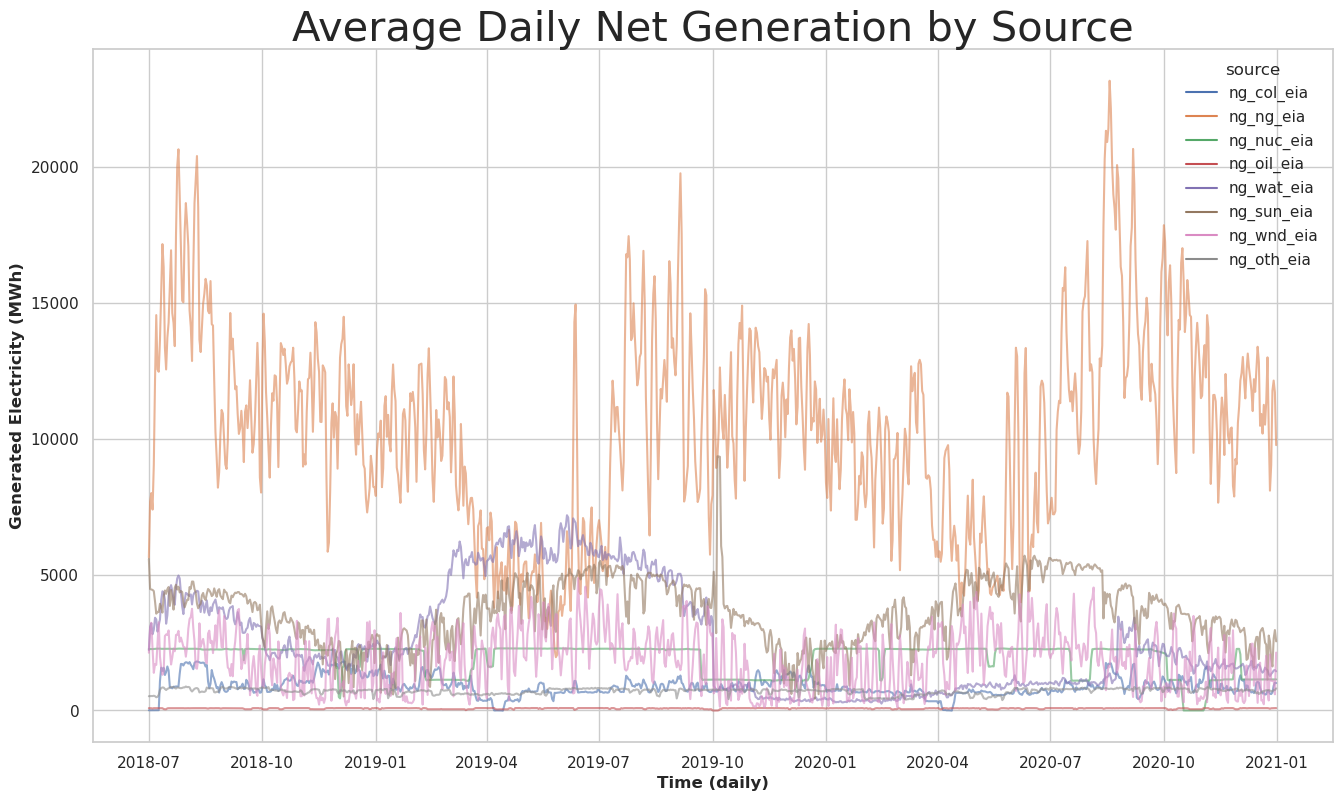

In [133]:
sns.lineplot(x="date", y="generation", hue="source", data=df_long, alpha=0.6) # , palette=palette
plt.title("Average Daily Net Generation by Source")
plt.xlabel("Time (daily)")
plt.ylabel("Generated Electricity (MWh)")
plt.show()

## Hourly

In [134]:
df_gen_hr = df[['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
                'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']]
df_hourly_gen_by_source = df_gen_hr.groupby(df['hour']).mean()

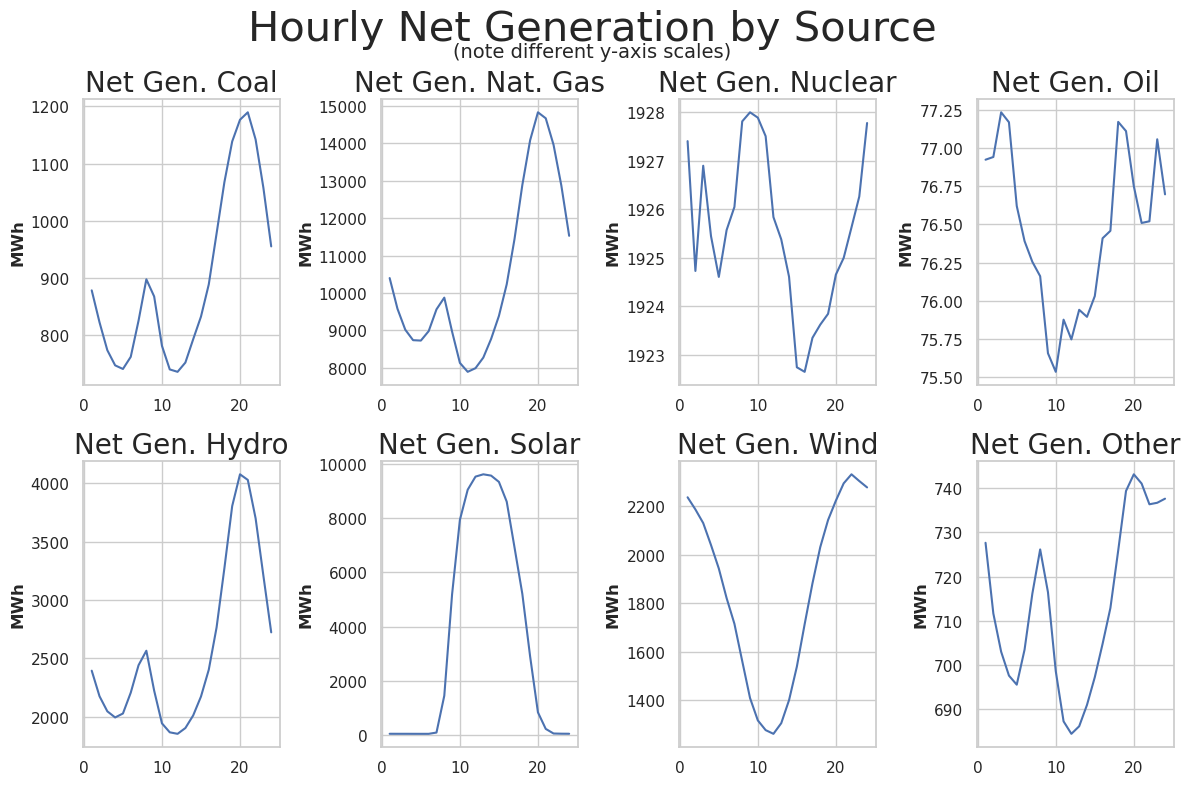

In [135]:
# create a list of columns to plot
cols = ['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
        'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']

# create a figure and axis array with 8 subplots
fig, ax = plt.subplots(2, 4, figsize=(12, 8))

# flatten the axis array so that it can be easily indexed
ax = ax.flatten()

# loop over each column to be plotted and set the title accordingly
for i, col in enumerate(cols):
    title = ''
    ylabel= 'MWh'
    if col == 'ng_col_eia':
        title = 'Net Gen. Coal'
    elif col == 'ng_ng_eia':
        title = 'Net Gen. Nat. Gas'
    elif col == 'ng_nuc_eia':
        title = 'Net Gen. Nuclear'
    elif col == 'ng_oil_eia':
        title = 'Net Gen. Oil'
    elif col == 'ng_wat_eia':
        title = 'Net Gen. Hydro'
    elif col == 'ng_sun_eia':
        title = 'Net Gen. Solar'
    elif col == 'ng_wnd_eia':
        title = 'Net Gen. Wind'
    elif col == 'ng_oth_eia':
        title = 'Net Gen. Other'
    # plot the data for the current column on the current subplot axis
    sns.lineplot(x=range(1,25), y=col, data=df_hourly_gen_by_source, ax=ax[i])
    # set the title for the current subplot axis
    ax[i].set_title(title, fontsize=20)
    ax[i].set_ylabel(ylabel, fontsize=12)

# add a title and subtitle to the entire figure
fig.suptitle("Hourly Net Generation by Source", fontsize=30)
fig.text(0.5, 0.92, "(note different y-axis scales)", ha='center', fontsize=14)

# remove unused subplots and adjust the layout
fig.tight_layout()

# show the plot
plt.show()


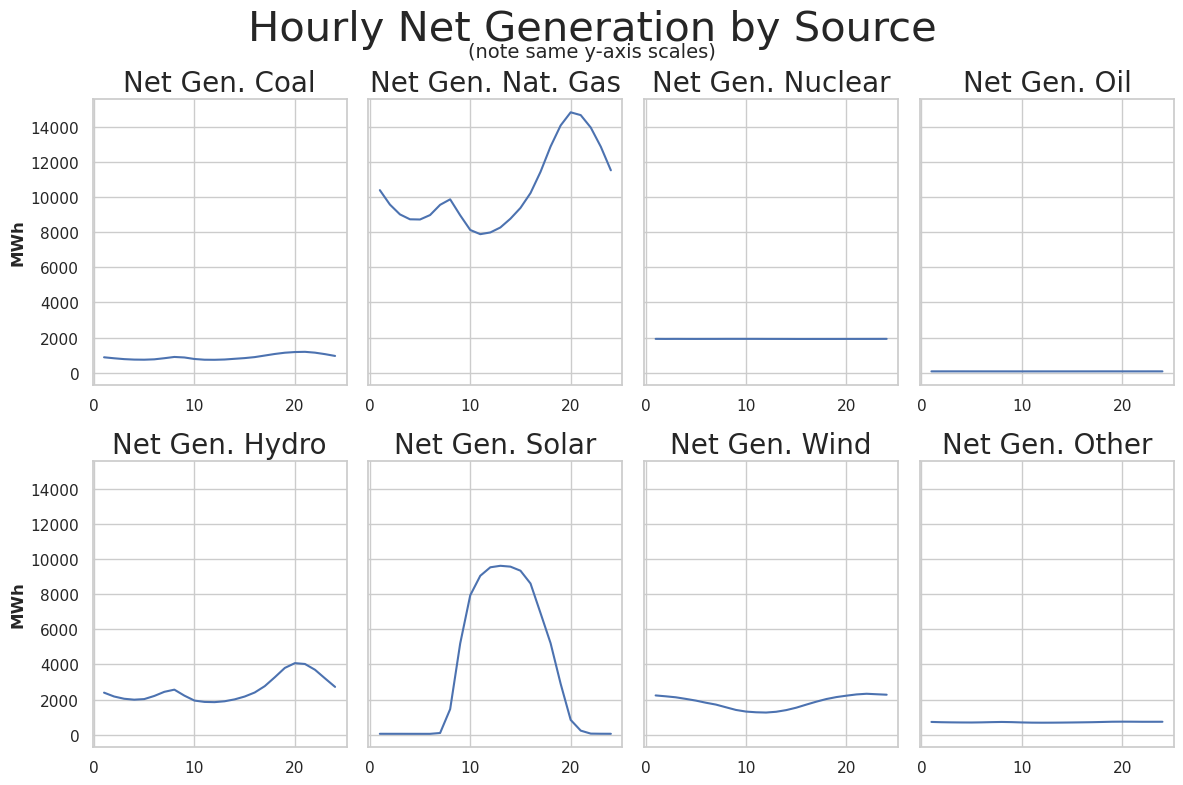

In [136]:
# create a list of columns to plot
cols = ['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
        'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']

# create a figure and axis array with 8 subplots
fig, ax = plt.subplots(2, 4, figsize=(12, 8), sharey=True)

# flatten the axis array so that it can be easily indexed
ax = ax.flatten()

# loop over each column to be plotted and set the title accordingly
for i, col in enumerate(cols):
    title = ''
    ylabel= 'MWh'
    if col == 'ng_col_eia':
        title = 'Net Gen. Coal'
    elif col == 'ng_ng_eia':
        title = 'Net Gen. Nat. Gas'
    elif col == 'ng_nuc_eia':
        title = 'Net Gen. Nuclear'
    elif col == 'ng_oil_eia':
        title = 'Net Gen. Oil'
    elif col == 'ng_wat_eia':
        title = 'Net Gen. Hydro'
    elif col == 'ng_sun_eia':
        title = 'Net Gen. Solar'
    elif col == 'ng_wnd_eia':
        title = 'Net Gen. Wind'
    elif col == 'ng_oth_eia':
        title = 'Net Gen. Other'
    # plot the data for the current column on the current subplot axis
    sns.lineplot(x=range(1,25), y=col, data=df_hourly_gen_by_source, ax=ax[i])
    # set the title for the current subplot axis
    ax[i].set_title(title, fontsize=20)
    ax[i].set_ylabel(ylabel, fontsize=12)

# add a title and subtitle to the entire figure
fig.suptitle("Hourly Net Generation by Source", fontsize=30)
fig.text(0.5, 0.92, "(note same y-axis scales)", ha='center', fontsize=14)

# remove unused subplots and adjust the layout
fig.tight_layout()

# show the plot
plt.show()


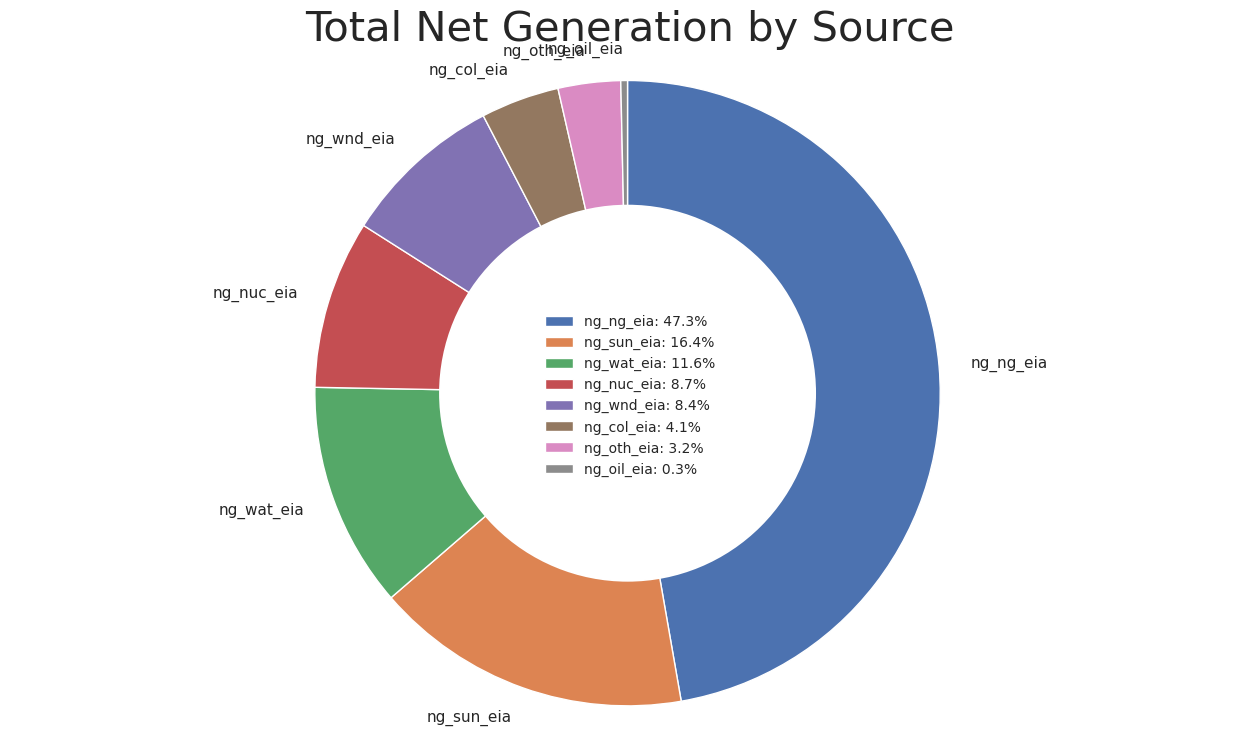

In [138]:
df_ng = df[['ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia',
        'ng_wat_eia', 'ng_sun_eia', 'ng_wnd_eia', 'ng_oth_eia']]

# Calculate the total values
total = df_ng.sum().sum()

# Calculate the percentage of each column
percentages = 100 * df_ng.sum() / total

# Sort the columns in descending order
percentages = percentages.sort_values(ascending=False)

# Create a list of labels and values
labels = percentages.index
values = percentages.values

# Plot the donut chart
fig, ax = plt.subplots()
ax.pie(values, labels=labels, startangle=90, counterclock=False, wedgeprops={'width':0.5})
ax.axis('equal')

# Add a circle in the center
center = plt.Circle((0,0), 0.60, color='white', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(center)

# Add the legend
legend_entries = [f"{l}: {v:.1f}%" for l, v in zip(labels, values)]
ax.legend(legend_entries, loc="center", bbox_to_anchor=(0.5, 0.5), fontsize=10)

# Remove the frame and add a background color to the legend
ax.set_frame_on(False)
ax.set_facecolor('white')

# Add the title
plt.title("Total Net Generation by Source")

# Show the plot
plt.show()

# Correlation Matrices

[Data Dictionary](https://docs.google.com/spreadsheets/d/1gTXbv5MtwQw57wvq6L5lmz6tOKV9onCNRzoJpwgTbFY/edit?usp=sharing)

## Generation

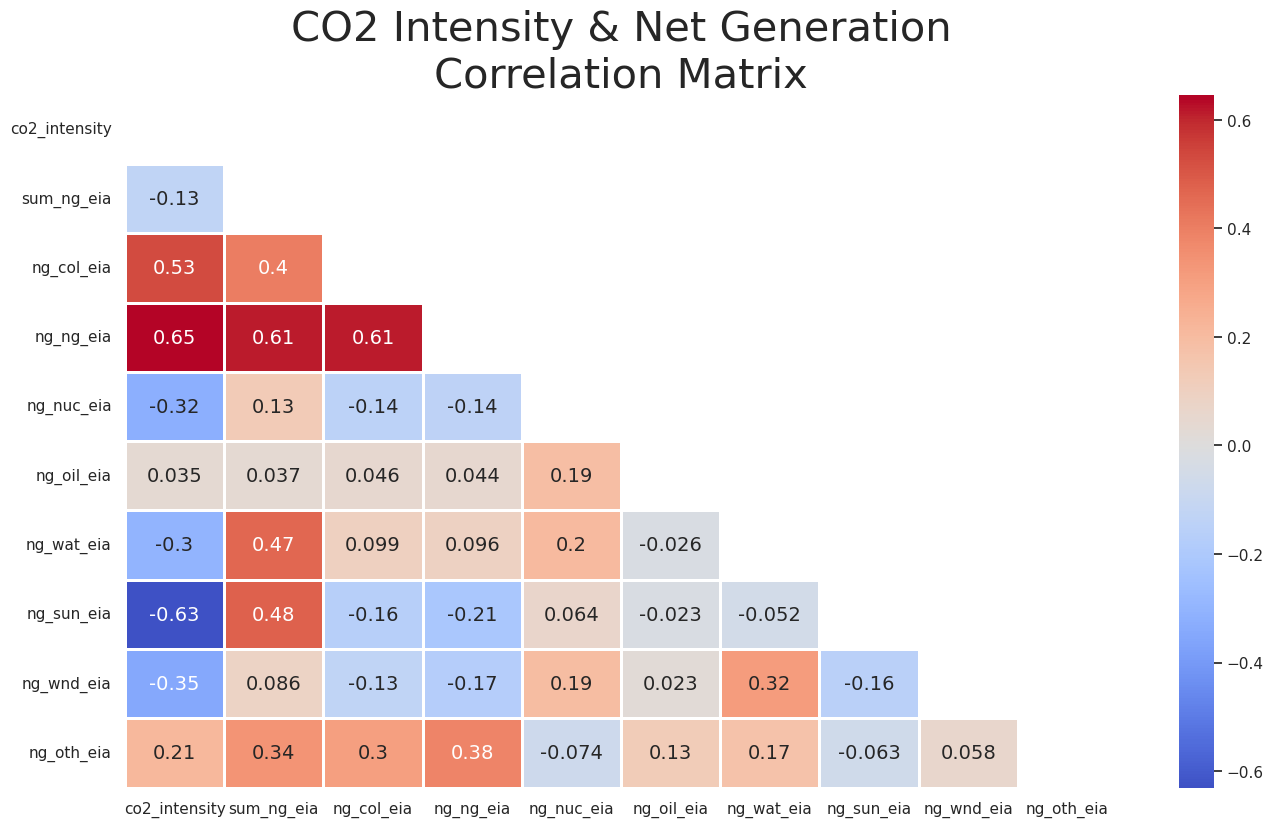

In [139]:
df_corr = df[['co2_emissions_intensity_for_consumed_electricity_eia', 'sum_ng_eia', 
              'ng_col_eia', 'ng_ng_eia', 'ng_nuc_eia', 'ng_oil_eia', 'ng_wat_eia', 'ng_sun_eia',
              'ng_wnd_eia', 'ng_oth_eia']].rename(columns={'co2_emissions_intensity_for_consumed_electricity_eia': 'co2_intensity'})

# Calculate the correlation matrix
corr = df_corr.corr()

# Mask the redundant upper half of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', center=0, linewidths=1, annot_kws={"size": 14})

# Add a title
plt.title("CO2 Intensity & Net Generation\nCorrelation Matrix")

# Show the plot
plt.show()

## Demand

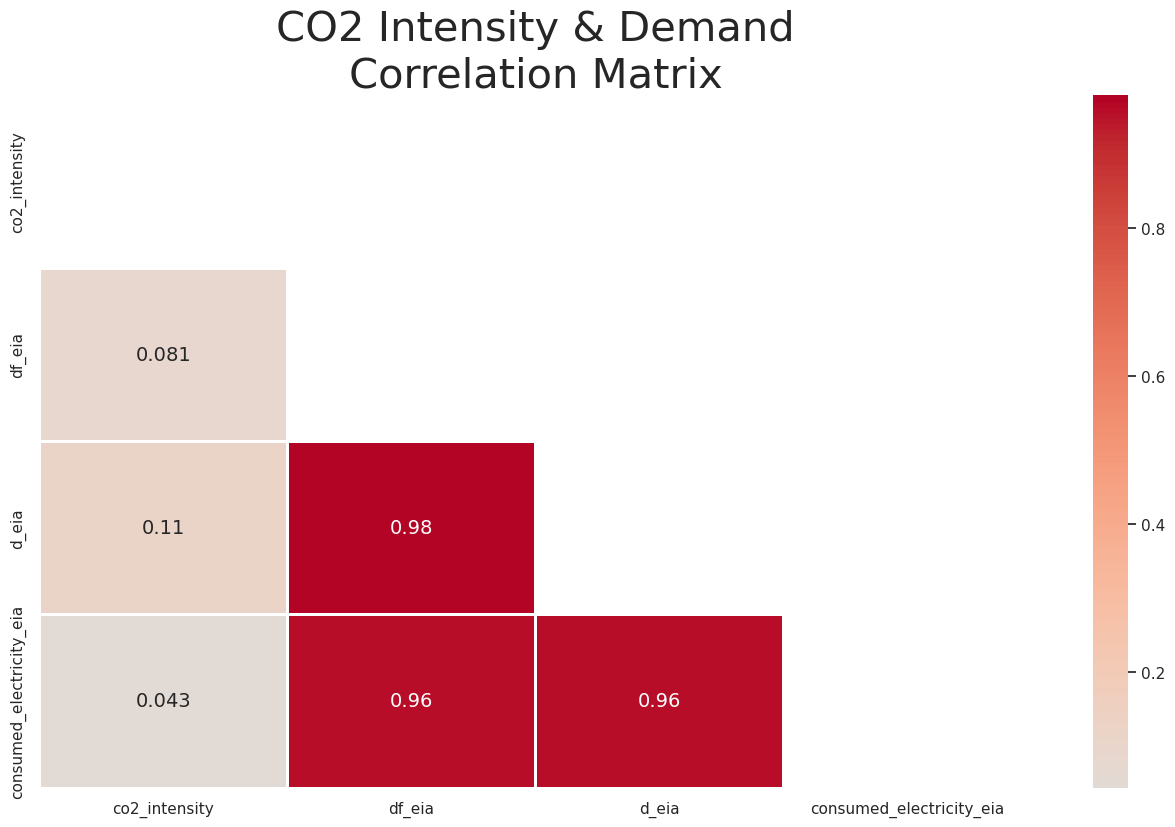

In [140]:
df_corr = df[['co2_emissions_intensity_for_consumed_electricity_eia',
              'df_eia',
              'd_eia',
              'consumed_electricity_eia']].rename(columns={'co2_emissions_intensity_for_consumed_electricity_eia': 'co2_intensity'})

# Calculate the correlation matrix
corr = df_corr.corr()

# Mask the redundant upper half of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', center=0, linewidths=1, annot_kws={"size": 14})

# Add a title
plt.title("CO2 Intensity & Demand\nCorrelation Matrix")

# Show the plot
plt.show()

## Interchange

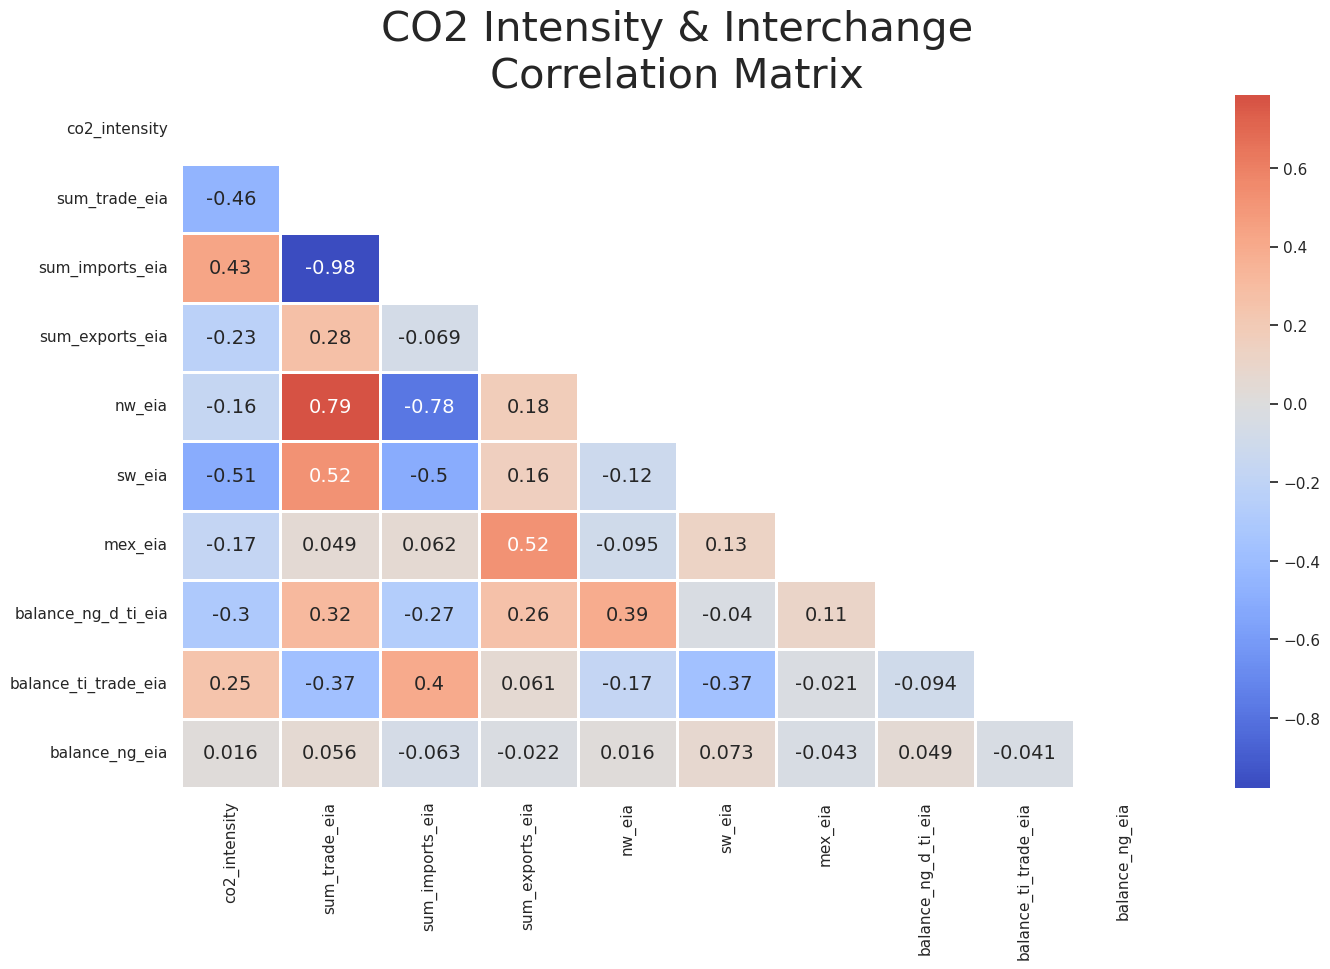

In [141]:
# Exclude cal, car, cent, fla, mida, midw, ne, ny, se, ten, tex, can b/c no interchange

df_corr = df[['co2_emissions_intensity_for_consumed_electricity_eia', 'sum_trade_eia',
       'sum_imports_eia', 'sum_exports_eia', 'nw_eia', 'sw_eia', 'mex_eia',
       'balance_ng_d_ti_eia', 'balance_ti_trade_eia', 'balance_ng_eia',]].rename(columns={'co2_emissions_intensity_for_consumed_electricity_eia': 'co2_intensity'})

# Calculate the correlation matrix
corr = df_corr.corr()

# Mask the redundant upper half of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', center=0, linewidths=1, annot_kws={"size": 14})

# Add a title
plt.title("CO2 Intensity & Interchange\nCorrelation Matrix")

# Show the plot
plt.show()

Southwest interchange pretty correlated to CO2 intensity.

## Emissions

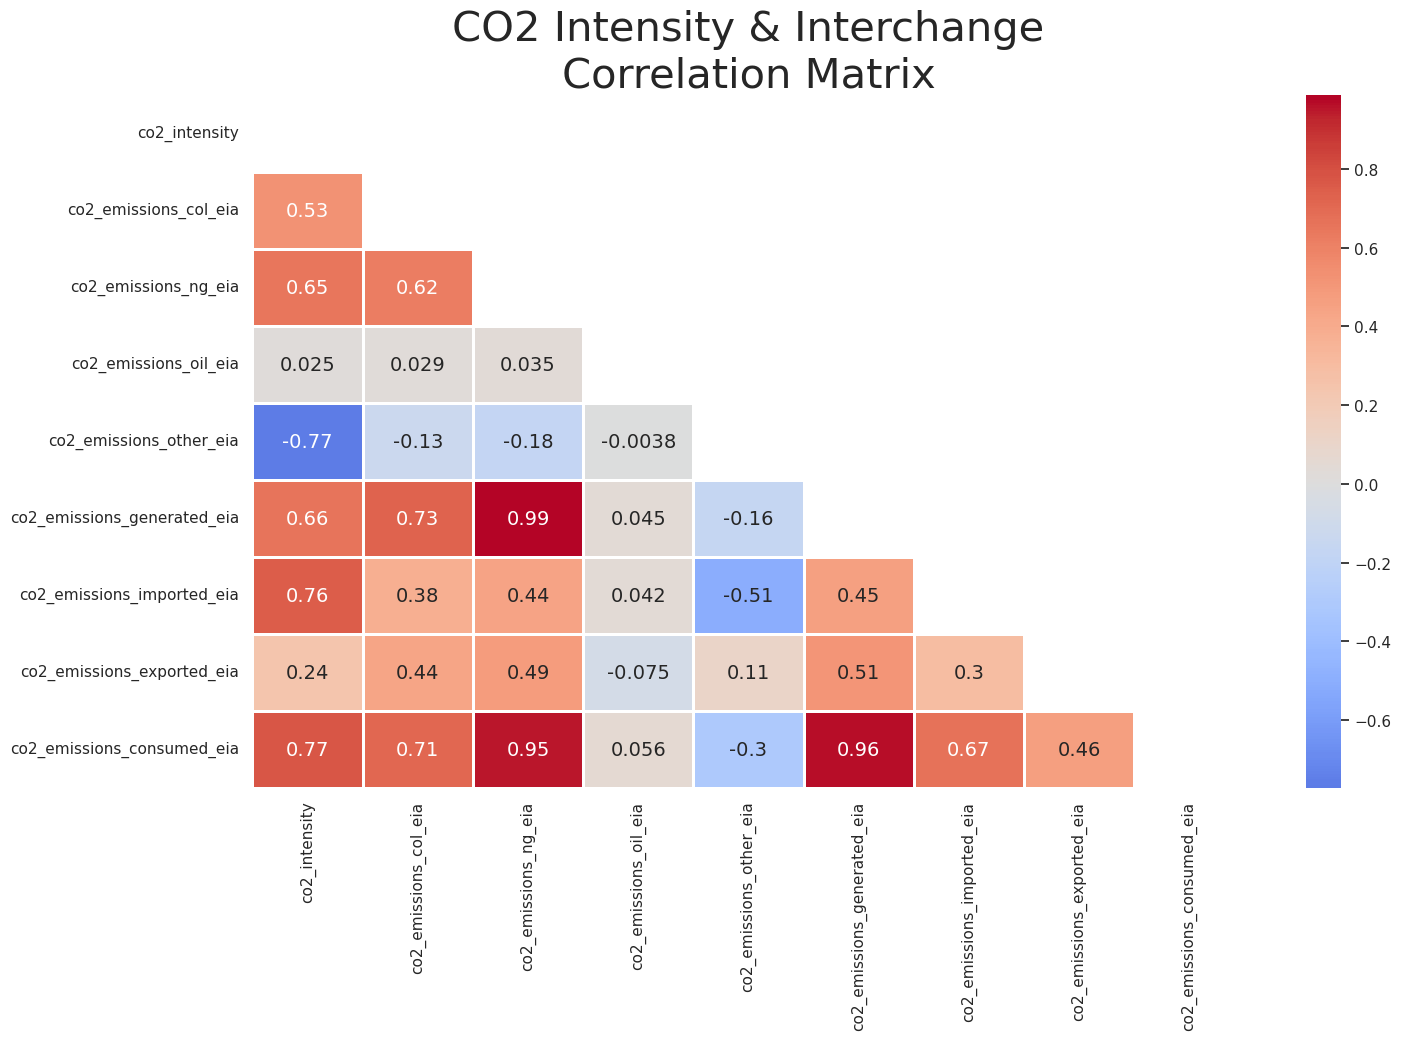

In [142]:
df_corr = df[['co2_emissions_intensity_for_consumed_electricity_eia', 'co2_emissions_col_eia',
       'co2_emissions_ng_eia', 'co2_emissions_oil_eia', 'co2_emissions_other_eia',
       'co2_emissions_generated_eia', 'co2_emissions_imported_eia',
       'co2_emissions_exported_eia', 'co2_emissions_consumed_eia']].rename(columns={'co2_emissions_intensity_for_consumed_electricity_eia': 'co2_intensity'})

# Calculate the correlation matrix
corr = df_corr.corr()

# Mask the redundant upper half of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', center=0, linewidths=1, annot_kws={"size": 14})

# Add a title
plt.title("CO2 Intensity & Interchange\nCorrelation Matrix")

# Show the plot
plt.show()

In [143]:
corr_all = df.corr()
large_corr = corr_all[abs(corr_all['co2_emissions_intensity_for_consumed_electricity_eia']) >= 0.1]['co2_emissions_intensity_for_consumed_electricity_eia']
large_corr_sorted = abs(large_corr).drop(['co2_emissions_intensity_for_consumed_electricity_eia',
                                          'co2_emissions_intensity_for_generated_electricity_eia']).sort_values(ascending=False)
large_corr_sorted

co2_emissions_consumed_eia               0.774757
co2_emissions_other_eia                  0.771129
co2_emissions_imported_eia               0.755067
renewables                               0.752860
sum_of_emissions                         0.655602
co2_emissions_generated_eia              0.655587
co2_emissions_ng_eia                     0.648849
ng_ng_eia                                0.646255
total_weighted_radiation_1_day_ahead     0.645341
total_weighted_radiation_2_days_ahead    0.640936
total_weighted_radiation_4_days_ahead    0.640746
total_weighted_radiation_3_days_ahead    0.640003
ng_sun_eia                               0.630407
solar                                    0.629082
thermal                                  0.622951
total_weighted_radiation_now             0.577964
imports                                  0.558296
co2_emissions_col_eia                    0.528077
ng_col_eia                               0.527529
sw_eia                                   0.508335
